In [1]:
# Starbucks Store Analysis using Machine Learning
# This project utilized machine learning algorithms, including K-Means Clustering and Random Forest Classification, 
# to analyze Starbucks' store data and ownership types. 
# Code and guidance were supported by AI assistance (ChatGPT, OpenAI, 2024).
#This notebook uses the "Starbucks World Locations" dataset, publicly available on Kaggle:
"""https://www.kaggle.com/starbucks-worldwide-locations."""


"""
References:
OpenAI. (2024). ChatGPT (Version 4.0) [AI language model]. https://openai.com
"""

'\nReferences:\nOpenAI. (2024). ChatGPT (Version 4.0) [AI language model]. https://openai.com\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Load the dataset

In [ ]:
file_path = 'directory.csv'
data = pd.read_csv(file_path)

### Step 1: Visualizing Missing Values (Heatmap) 

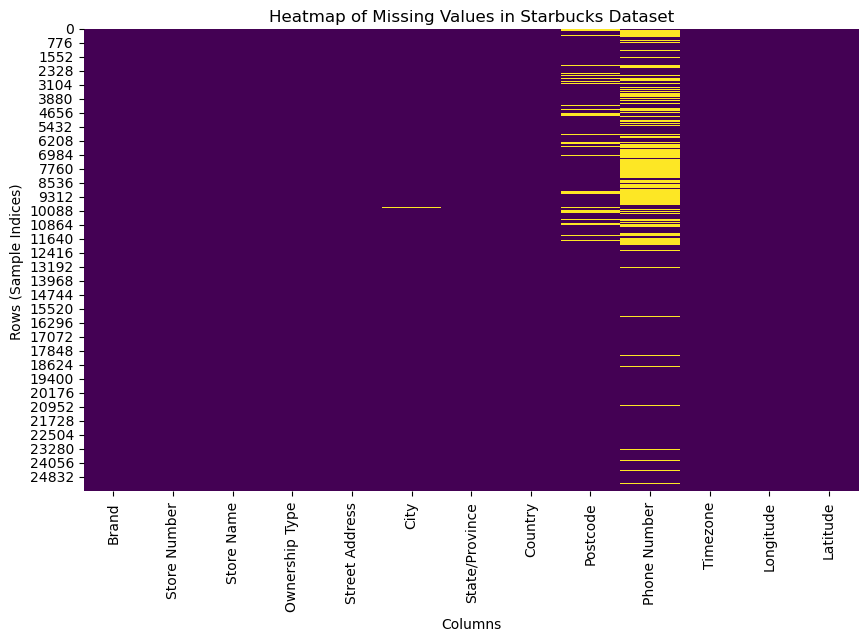

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Heatmap of Missing Values in Starbucks Dataset")
plt.xlabel("Columns")
plt.ylabel("Rows (Sample Indices)")
plt.show()

### Step 2: Bar Chart of Ownership Type

/tmp/ipykernel_122418/1263948738.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ownership_counts.values, y=ownership_counts.index, palette='viridis')


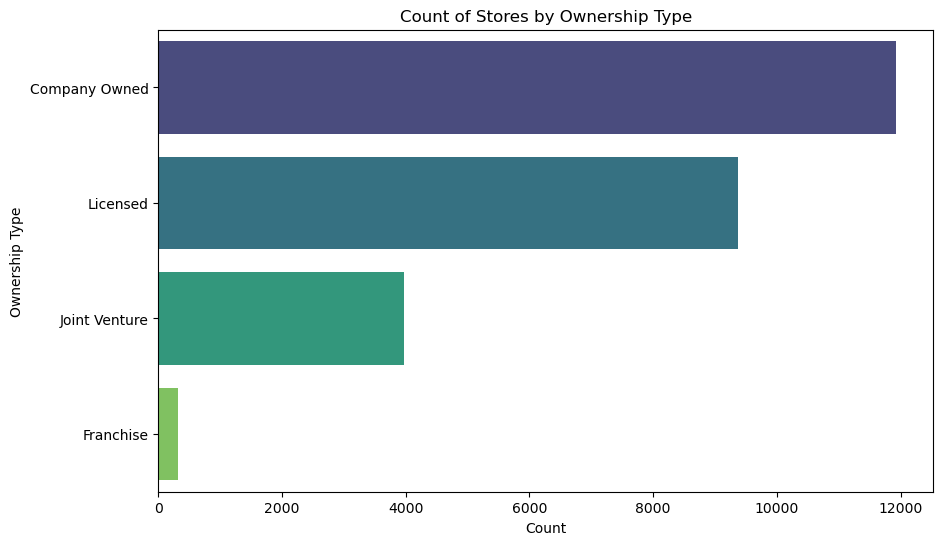

In [45]:
plt.figure(figsize=(10, 6))
ownership_counts = data['Ownership Type'].value_counts()
sns.barplot(x=ownership_counts.values, y=ownership_counts.index, palette='viridis')
plt.title("Count of Stores by Ownership Type")
plt.xlabel("Count")
plt.ylabel("Ownership Type")
plt.show()

### Step 3: Geographic Heat Map

In [ ]:
geo_data = data.dropna(subset=['Latitude', 'Longitude'])
starbucks_map = folium.Map(location=[20, 0], zoom_start=2)
heat_data = list(zip(geo_data['Latitude'], geo_data['Longitude']))
HeatMap(heat_data).add_to(starbucks_map)
map_file_path = "Starbucks_Global_Heatmap.html"
starbucks_map.save(map_file_path)
print(f"Geographic heat map saved to {map_file_path}. Open this file in a web browser to view it.")

Geographic heat map saved to Starbucks_Global_Heatmap.html. Open this file in a web browser to view it.


### Step 4: Data Analysis

In [ ]:
country_counts = data['Country'].value_counts().head(10)
print("Top 10 countries by Starbucks store count:")
print(country_counts)

ownership_by_country = data.groupby(['Country', 'Ownership Type']).size().unstack(fill_value=0)
print("Ownership type distribution by country:")
print(ownership_by_country.head())

Top 10 countries by Starbucks store count:
Country
US    13608
CN     2734
CA     1468
JP     1237
KR      993
GB      901
MX      579
TW      394
TR      326
PH      298
Name: count, dtype: int64
Ownership type distribution by country:
Ownership Type  Company Owned  Franchise  Joint Venture  Licensed
Country                                                          
AD                          0          0              0         1
AE                          0          0              0       144
AR                          0          0              1       107
AT                         17          0              0         1
AU                          0          0              0        22


### Step 5: Data Preprocessing

In [ ]:
# Fill missing values
data['Postcode'] = data['Postcode'].fillna('Unknown').astype(str)
data['Phone Number'] = data['Phone Number'].fillna('Unknown').astype(str)

# Encode Ownership Type
label_encoder = LabelEncoder()
data['Ownership Type Encoded'] = label_encoder.fit_transform(data['Ownership Type'])

#### Visualize Ownership Type Distribution

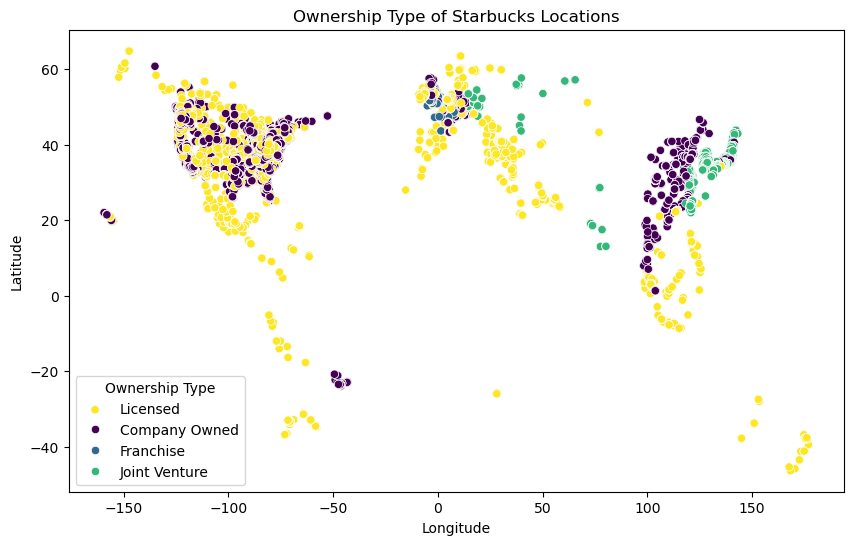

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data['Longitude'], 
    y=data['Latitude'], 
    hue=data['Ownership Type Encoded'], 
    palette='viridis'
)
plt.title("Ownership Type of Starbucks Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Ownership Type", labels=["Licensed", "Company Owned", "Franchise", "Joint Venture"])
#.show()
plt.savefig("scatter.png")

### Step 6: K-Means Clustering

In [ ]:
# Select features for clustering
clustering_features = data[['Latitude', 'Longitude', 'Ownership Type Encoded']].dropna()

# Standardize the data for clustering
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

#### Find Optimal Hyperparameters

[48279.41721253983, 28405.814147258265, 18422.373252178335, 15000.938037634523, 12850.398676974117, 10903.67099193138, 9060.355474457747, 7720.047356942271]


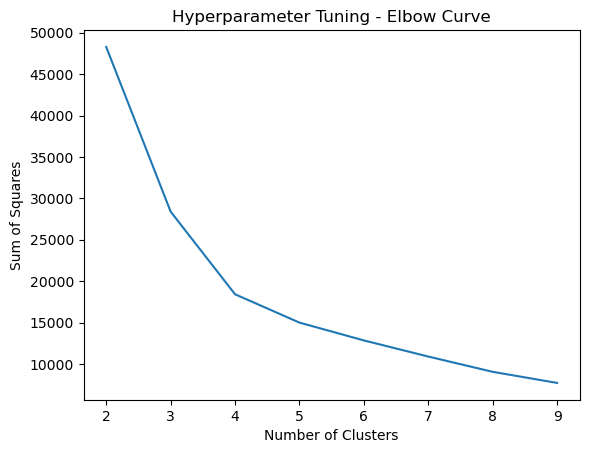

In [61]:
# Elbow Method For K-Means Optimal Clustering
cluster_inertias = []
for c in range(2, 10):
    # Apply K-Means with 3 clusters
    kmeans = KMeans(n_clusters=c, n_init=10, random_state=42)
    kmeans.fit(clustering_features_scaled)
    cluster_inertias.append(kmeans.inertia_)
print(cluster_inertias)
plt.figure()
plt.plot(range(2, 10), cluster_inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squares")
plt.title("Hyperparameter Tuning - Elbow Curve")
plt.savefig("elbow_curve.png")
plt.show()

#### Apply K-Means with 3 clusters

In [71]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clustering_features['Cluster'] = kmeans.fit_predict(clustering_features_scaled)

# Add cluster labels back to the dataset
data['Cluster'] = kmeans.predict(scaler.transform(data[['Latitude', 'Longitude', 'Ownership Type Encoded']].fillna(0)))

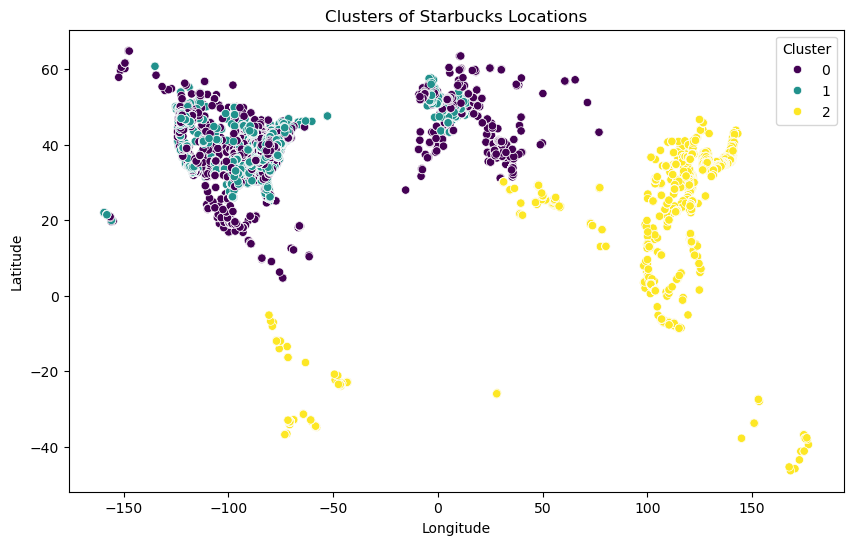

In [63]:
# Visualize the cluster distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=clustering_features['Longitude'], 
    y=clustering_features['Latitude'], 
    hue=clustering_features['Cluster'], 
    palette='viridis'
)
plt.title("Clusters of Starbucks Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

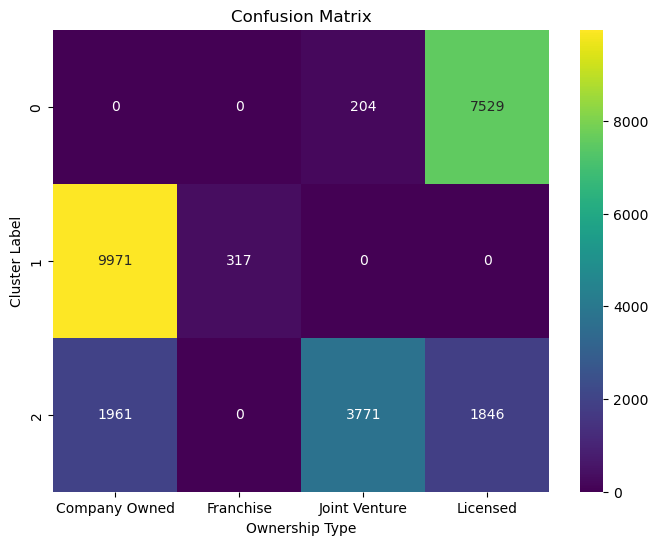

In [78]:
# Generate confusion matrix
conf_matrix = confusion_matrix(clustering_features['Cluster'].to_list(), clustering_features['Ownership Type Encoded'].to_list())
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix[:-1], annot=True, fmt='d', cmap='viridis', cbar=True, 
            xticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Ownership Type")
plt.ylabel("Cluster Label")
plt.savefig("cluster_confusion_matrix.png")
plt.show()

### Step 6.5: Just Geographic Clustering

In [79]:
# Select features for clustering
clustering_features = data[['Latitude', 'Longitude']].dropna()

# Standardize the data for clustering
scaler = StandardScaler()
clustering_features_scaled = scaler.fit_transform(clustering_features)

#### Find Optimal Hyperparameters

[23390.3335840574, 13581.383559902146, 9579.312461749241, 7297.689186355589, 5044.716748946196, 4134.088154973253, 3384.4322546326293, 2708.8060292815007]


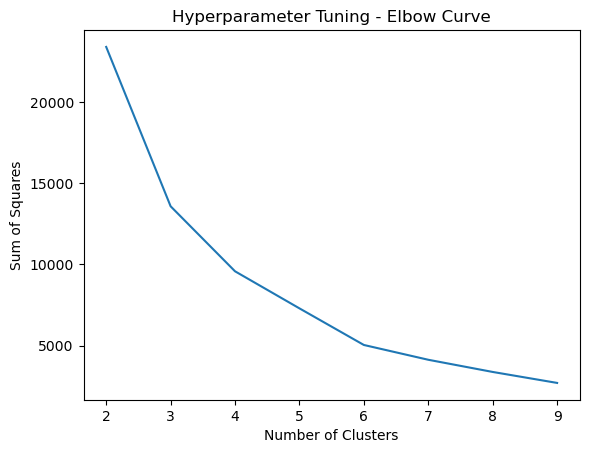

In [80]:
# Elbow Method For K-Means Optimal Clustering
cluster_inertias = []
for c in range(2, 10):
    # Apply K-Means with 3 clusters
    kmeans = KMeans(n_clusters=c, n_init=10, random_state=42)
    kmeans.fit(clustering_features_scaled)
    cluster_inertias.append(kmeans.inertia_)
print(cluster_inertias)
plt.figure()
plt.plot(range(2, 10), cluster_inertias)
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squares")
plt.title("Hyperparameter Tuning - Elbow Curve")
plt.savefig("elbow_curve.png")
plt.show()

#### Apply K-Means with 5 clusters (Optimal for Elbow method)

In [93]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clustering_features['Cluster'] = kmeans.fit_predict(clustering_features_scaled)

# Add cluster labels back to the dataset
data['ClusterGeographic'] = kmeans.predict(scaler.transform(data[['Latitude', 'Longitude']].fillna(0)))

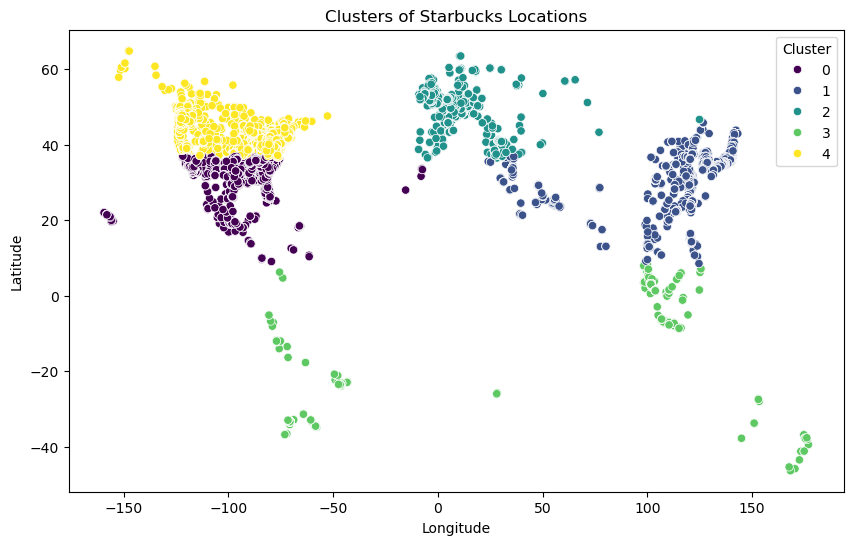

In [96]:
# Visualize the cluster distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=clustering_features['Longitude'], 
    y=clustering_features['Latitude'], 
    hue=clustering_features['Cluster'], 
    palette='viridis'
)
plt.title("Clusters of Starbucks Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.savefig("geographic_clustering.png")
plt.show()

### Step 7: Random Forest Classifier 

In [66]:
# Prepare the data for classification
classification_features = data[['Latitude', 'Longitude']].dropna()
classification_labels = data.loc[classification_features.index, 'Ownership Type Encoded']

X = classification_features
y = classification_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [68]:
print(label_encoder.classes_)

['Company Owned' 'Franchise' 'Joint Venture' 'Licensed']


Random Forest Classifier Results:
Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      3568
           1       0.55      0.54      0.55        94
           2       0.95      0.98      0.97      1222
           3       0.62      0.58      0.60      2796

    accuracy                           0.70      7680
   macro avg       0.70      0.70      0.70      7680
weighted avg       0.70      0.70      0.70      7680



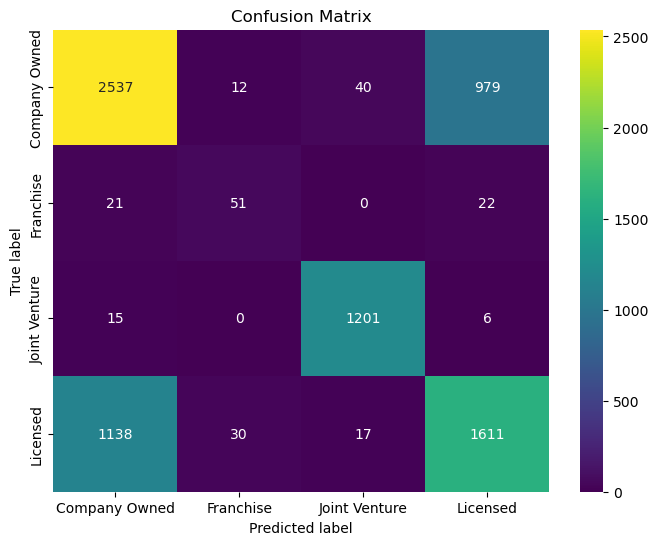

In [82]:
# Evaluate the model
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=True, 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.savefig("random_forest_confusion.png")
plt.show()